In [10]:
# 0) Imports
import numpy as np, random, torch, pandas as pd, math
import torch, torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
df1 = pd.read_excel("./cleaned.xlsx")
print(df1.head())

       TIMESTAMP  TARGETVAR       U10       V10      U100      V100  \
0  20120101 1:00   0.000000  2.124600 -2.681966  2.864280 -3.666076   
1  20120101 2:00   0.054879  2.521695 -1.796960  3.344859 -2.464761   
2  20120101 3:00   0.110234  2.672210 -0.822516  3.508448 -1.214093   
3  20120101 4:00   0.165116  2.457504 -0.143642  3.215233 -0.355546   
4  20120101 5:00   0.156940  2.245898  0.389576  2.957678  0.332701   

             DATETIME  
0 2012-01-01 01:00:00  
1 2012-01-01 02:00:00  
2 2012-01-01 03:00:00  
3 2012-01-01 04:00:00  
4 2012-01-01 05:00:00  


In [7]:
# =========================
# 1) Load & clean
# =========================
df = pd.read_excel("./WindPowerForecastingData.xlsx")
df["DATETIME"] = pd.to_datetime(df["TIMESTAMP"], format="%Y%m%d %H:%M", errors="coerce")
df = df.sort_values("DATETIME").reset_index(drop=True)

TARGET_COL = "TARGETVAR"  # change this to actual target column name
df_clean = df.drop(columns=[c for c in ["TIMESTAMP","DATETIME"] if c in df.columns]).copy()
cols = [TARGET_COL] + [c for c in df_clean.columns if c != TARGET_COL]
df_clean = df_clean[cols].astype(float)

##############3
n_before = len(df_clean)
df_clean = df_clean.dropna(subset=[TARGET_COL]).copy()
print(f"Dropped {n_before - len(df_clean)} rows with missing target.")
##############

print (df_clean.head())
# =========================
# 2) Chronological split
# =========================
n = len(df_clean)
train_n = int(0.8 * n)
train_df = df_clean.iloc[:train_n].copy()
test_df  = df_clean.iloc[train_n:].copy()
print(".......................")
print(train_df[[TARGET_COL]])
y_train = train_df[[TARGET_COL]].values
print(".....y train ..................")
print(y_train)
X_train = train_df.drop(columns=[TARGET_COL]).values
print(".....x train ..................")
print(X_train)
y_test  = test_df[[TARGET_COL]].values
X_test  = test_df.drop(columns=[TARGET_COL]).values

print(".....size ..................")
print("y_train shape:", y_train.shape)
print("y_train min/max:", np.nanmin(y_train), np.nanmax(y_train))
print(".....end size ..................")

x_scaler = MinMaxScaler().fit(X_train)
#y_scaler = MinMaxScaler().fit(y_train)

X_train_s = x_scaler.transform(X_train)
X_test_s  = x_scaler.transform(X_test)
# y_train_s = y_scaler.transform(y_train)
# y_test_s  = y_scaler.transform(y_test)

print("y_train min/max:", y_train.min(), y_train.max())
print("X_train min/max:", X_train.min(), X_train.max())


Dropped 35 rows with missing target.
   TARGETVAR       U10       V10      U100      V100
0   0.000000  2.124600 -2.681966  2.864280 -3.666076
1   0.054879  2.521695 -1.796960  3.344859 -2.464761
2   0.110234  2.672210 -0.822516  3.508448 -1.214093
3   0.165116  2.457504 -0.143642  3.215233 -0.355546
4   0.156940  2.245898  0.389576  2.957678  0.332701
.......................
       TARGETVAR
0       0.000000
1       0.054879
2       0.110234
3       0.165116
4       0.156940
...          ...
13414   0.665915
13415   0.758011
13416   0.862043
13417   0.896250
13418   0.807067

[13412 rows x 1 columns]
.....y train ..................
[[0.        ]
 [0.05487912]
 [0.110234  ]
 ...
 [0.86204301]
 [0.89625034]
 [0.807067  ]]
.....x train ..................
[[ 2.12460014 -2.68196637  2.86427959 -3.66607576]
 [ 2.52169465 -1.79696009  3.34485867 -2.46476146]
 [ 2.67220986 -0.82251622  3.50844802 -1.21409294]
 ...
 [-3.47043383 -4.0529605  -5.47409945 -7.29139776]
 [-3.93802336 -3.85843369 -6

In [8]:
#reproducibility & device
SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED) #creates the same sequences acroess the numpy and python
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED) #since the starting weights are randomly initialized,  these starting weights are the same every single time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [ ]:
# data helpers
def make_sequences(X, y, lookback):
    """
    Create the sequences for machine learning training
    X : input features 
    Y : target variable
    lookback : the amount of data used for training (eg : previous 12 hour data)
    """
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i, :])
        ys.append(y[i, 0])
    return np.array(Xs, np.float32), np.array(ys, np.float32).reshape(-1,1)

def build_loaders(X_tr_all, y_tr_all, X_te, y_te, lookback, batch_size=30, val_frac=0.2):
    """
    Create training and testing datasets to batch loaders for effective training
    X_tr_all
    y_tr_all
    X_te
    y_te
    
    """
    n = len(X_tr_all)
    val_len = max(1, int(val_frac * n))
    X_core, y_core = X_tr_all[:n-val_len], y_tr_all[:n-val_len]
    X_val,  y_val  = X_tr_all[n-val_len:], y_tr_all[n-val_len:]

    Xtr_seq, ytr_seq   = make_sequences(X_core, y_core, lookback)
    Xval_seq, yval_seq = make_sequences(X_val,  y_val,  lookback)
    Xte_seq, yte_seq   = make_sequences(X_te,   y_te,   lookback)

    train_ds = TensorDataset(torch.from_numpy(Xtr_seq),  torch.from_numpy(ytr_seq))
    val_ds   = TensorDataset(torch.from_numpy(Xval_seq), torch.from_numpy(yval_seq))
    test_ds  = TensorDataset(torch.from_numpy(Xte_seq),  torch.from_numpy(yte_seq))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader

# ---- model builder (returns plain layers)
def build_lstm_stack(input_size, h1, h2, h3, dropout=0.0):
    lstm1 = nn.LSTM(input_size, h1, num_layers=1, batch_first=True, dropout=0.0).to(device)
    lstm2 = nn.LSTM(h1,        h2, num_layers=1, batch_first=True, dropout=0.0).to(device)
    lstm3 = nn.LSTM(h2,        h3, num_layers=1, batch_first=True, dropout=0.0).to(device)
    do    = nn.Dropout(dropout).to(device)
    fc    = nn.Linear(h3, 1).to(device)
    return lstm1, lstm2, lstm3, do, fc

# ---- forward (no class)
def forward_pass(lstm1, lstm2, lstm3, do, fc, x):
    out, _ = lstm1(x)
    out, _ = lstm2(out)
    out, _ = lstm3(out)
    out = out[:, -1, :]
    out = do(out)
    return fc(out)

# ---- train one configuration; return best val RMSE + saved states
def train_once(X_train_s, y_train, X_test_s, y_test,
               n_steps, h1, h2, h3,
               lr=1e-3, batch_size=30, epochs=10, dropout=0.0):
    input_size = X_train_s.shape[1]
    train_loader, val_loader, test_loader = build_loaders(
        X_train_s, y_train, X_test_s, y_test, lookback=n_steps, batch_size=batch_size, val_frac=0.2
    )
    # if lookback too large -> not enough sequences
    if len(train_loader.dataset) < 10 or len(val_loader.dataset) < 10:
        return np.inf, None, None

    lstm1, lstm2, lstm3, do, fc = build_lstm_stack(input_size, h1, h2, h3, dropout=dropout)
    params = list(lstm1.parameters()) + list(lstm2.parameters()) + list(lstm3.parameters()) + list(fc.parameters())

    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(params, lr=lr)          # paper-style
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

    best_rmse = np.inf
    best_state = None  # dict of state_dicts

    for ep in range(epochs):
        # train
        for m in (lstm1, lstm2, lstm3, fc): m.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = forward_pass(lstm1, lstm2, lstm3, do, fc, xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(params, 1.0)
            optimizer.step()

        # validate
        for m in (lstm1, lstm2, lstm3, fc): m.eval()
        v_preds, v_trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                pb = forward_pass(lstm1, lstm2, lstm3, do, fc, xb)
                v_preds.append(pb.detach().cpu().numpy()); v_trues.append(yb.detach().cpu().numpy())
        yv = np.vstack(v_trues).reshape(-1)
        yp = np.vstack(v_preds).reshape(-1)
        val_rmse = np.sqrt(np.mean((yv - yp)**2))
        #   val_rmse = mean_squared_error(yv, yp, squared=False)
        scheduler.step(val_rmse)

        if val_rmse < best_rmse - 1e-6:
            best_rmse = val_rmse
            best_state = {
                "lstm1": {k: v.detach().cpu().clone() for k, v in lstm1.state_dict().items()},
                "lstm2": {k: v.detach().cpu().clone() for k, v in lstm2.state_dict().items()},
                "lstm3": {k: v.detach().cpu().clone() for k, v in lstm3.state_dict().items()},
                "fc":    {k: v.detach().cpu().clone() for k, v in fc.state_dict().items()},
            }

    if best_state is None:
        return np.inf, None, None

    # restore best
    lstm1.load_state_dict(best_state["lstm1"])
    lstm2.load_state_dict(best_state["lstm2"])
    lstm3.load_state_dict(best_state["lstm3"])
    fc.load_state_dict(best_state["fc"])
    for m in (lstm1, lstm2, lstm3, fc): m.eval()

    model_pack = (lstm1, lstm2, lstm3, do, fc)
    return best_rmse, model_pack, test_loader

# =========================
# Genetic Algorithm bits
# =========================
LOOKBACK_CHOICES = [3, 6, 12, 24, 36, 48]
H_CHOICES        = [50, 100, 200, 300, 500]
GA_POP, GA_GENS = 10, 6
GA_CX_RATE, GA_MUT_RATE = 0.4, 0.10

def random_individual():
    return (random.choice(LOOKBACK_CHOICES),
            random.choice(H_CHOICES),
            random.choice(H_CHOICES),
            random.choice(H_CHOICES))  # (n_steps, h1, h2, h3)

def crossover(p1, p2):
    if random.random() > GA_CX_RATE: return p1, p2
    cut = random.randint(1, 3)
    return (p1[:cut] + p2[cut:], p2[:cut] + p1[cut:])

def mutate(ind):
    ind = list(ind)
    for g in range(4):
        if random.random() < GA_MUT_RATE:
            if g == 0:
                choices = [x for x in LOOKBACK_CHOICES if x != ind[0]]
                ind[0] = random.choice(choices)
            else:
                choices = [x for x in H_CHOICES if x != ind[g]]
                ind[g] = random.choice(choices)
    return tuple(ind)

def tournament_select(pop, fits, k=3):
    idxs = random.sample(range(len(pop)), k)
    idxs.sort(key=lambda i: fits[i])
    return pop[idxs[0]]

def run_ga():
    pop = [random_individual() for _ in range(GA_POP)]
    best = (np.inf, None, None, None)  # (val_rmse, ind, model_pack, test_loader)
    cache = {}

    for gen in range(GA_GENS):
        fits, packs, tls = [], [], []
        for i, ind in enumerate(pop):
            if ind in cache:
                val_rmse, model_pack, tl = cache[ind]
            else:
                print(f"[Gen {gen+1}/{GA_GENS}] Eval {i+1}/{len(pop)}: {ind}")
                val_rmse, model_pack, tl = train_once(
                    X_train_s, y_train, X_test_s, y_test,
                    n_steps=ind[0], h1=ind[1], h2=ind[2], h3=ind[3],
                    lr=1e-3, batch_size=30, epochs=10, dropout=0.0
                )
                cache[ind] = (val_rmse, model_pack, tl)
            fits.append(val_rmse); packs.append(model_pack); tls.append(tl)

        # track best
        for ind, rmse, pack, tl in zip(pop, fits, packs, tls):
            if rmse < best[0]:
                best = (rmse, ind, pack, tl)
        print(f"  -> Best so far: RMSE={best[0]:.5f}, ind={best[1]}")

        # next generation (elitism + tournament + cx + mut)
        elite_idx = np.argsort(fits)[:2]
        new_pop = [pop[elite_idx[0]], pop[elite_idx[1]]]
        while len(new_pop) < GA_POP:
            p1 = tournament_select(pop, fits, k=3)
            p2 = tournament_select(pop, fits, k=3)
            c1, c2 = crossover(p1, p2)
            new_pop.extend([mutate(c1), mutate(c2)])
        pop = new_pop[:GA_POP]
    return best  # (best_val_rmse, best_individual, best_model_pack, best_test_loader)

# =========================
# Run GA, evaluate on TEST, save
# =========================
start = time.time()
best_val_rmse, best_ind, best_pack, best_test_loader = run_ga()
print("\n==== GA Best ====")
print("Best individual (n_steps, h1, h2, h3):", best_ind)
print(f"Best Val RMSE: {best_val_rmse:.6f} | Time: {(time.time()-start):.1f}s")

# Final TEST metrics
(lstm1, lstm2, lstm3, do, fc) = best_pack
preds, trues = [], []
with torch.no_grad():
    for xb, yb in best_test_loader:
        xb = xb.to(device); yb = yb.to(device)
        pb = forward_pass(lstm1, lstm2, lstm3, do, fc, xb)
        preds.append(pb.cpu().numpy()); trues.append(yb.cpu().numpy())
y_true = np.vstack(trues).reshape(-1)
y_pred = np.vstack(preds).reshape(-1)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
#rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
eps  = 1e-6
smape = np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))*100
print(f"\n=== TEST ===\nRMSE={rmse:.6f} | MAE={mae:.6f} | sMAPE={smape:.2f}%")

# Save checkpoint (layers only; still no classes)
torch.save({
    "lstm1": lstm1.state_dict(),
    "lstm2": lstm2.state_dict(),
    "lstm3": lstm3.state_dict(),
    "fc":    fc.state_dict(),
    "arch": {
        "input_size": X_train_s.shape[1],
        "lookback": best_ind[0],
        "h1": best_ind[1], "h2": best_ind[2], "h3": best_ind[3],
        "dropout": 0.0
    }
}, "glstm_noclass_best.pth")
print("Saved -> glstm_noclass_best.pth")


[Gen 1/6] Eval 1/10: (48, 50, 50, 200)
[Gen 1/6] Eval 2/10: (6, 100, 100, 50)
[Gen 1/6] Eval 3/10: (48, 500, 50, 500)


RMSE=0.205014 | MAE=0.159341 | sMAPE=63.50%


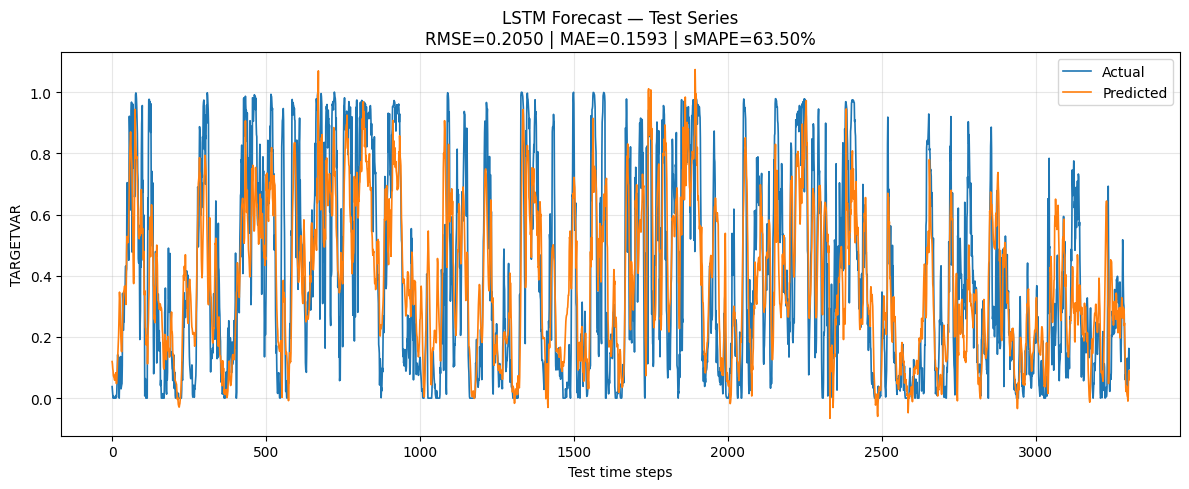

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# y_true, y_pred already built; TARGET_COL is your target's name
yt = np.asarray(y_true).reshape(-1)
yp = np.asarray(y_pred).reshape(-1)

# Basic metrics (on original scale)
rmse = np.sqrt(np.mean((yt - yp)**2))
#rmse = mean_squared_error(yt, yp, squared=False)
mae  = mean_absolute_error(yt, yp)
eps  = 1e-6
smape = np.mean(2*np.abs(yp - yt) / (np.abs(yt) + np.abs(yp) + eps)) * 100

print(f"RMSE={rmse:.6f} | MAE={mae:.6f} | sMAPE={smape:.2f}%")

# --- Plot: full test series ---
plt.figure(figsize=(12,5))
plt.plot(yt, label="Actual", linewidth=1.2)
plt.plot(yp, label="Predicted", linewidth=1.2)
plt.title(f"LSTM Forecast — Test Series\nRMSE={rmse:.4f} | MAE={mae:.4f} | sMAPE={smape:.2f}%")
plt.xlabel("Test time steps")
plt.ylabel(TARGET_COL)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- (Optional) Zoom into a window, e.g., first 500 points ---
# k = min(500, len(yt))
# plt.figure(figsize=(12,5))
# plt.plot(yt[:k], label="Actual", linewidth=1.2)
# plt.plot(yp[:k], label="Predicted", linewidth=1.2)
# plt.title(f"Zoomed view (first {k} steps)")
# plt.xlabel("Test time steps")
# plt.ylabel(TARGET_COL)
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# --- (Optional) Parity / scatter plot ---
# plt.figure(figsize=(5,5))
# plt.scatter(yt, yp, s=8, alpha=0.6)
# lims = [min(yt.min(), yp.min()), max(yt.max(), yp.max())]
# plt.plot(lims, lims, linestyle="--")  # y=x line
# plt.title("Predicted vs Actual")
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()
